# RNN Model

## 1. Import libraries

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2. Đọc Dataset và chia data thành 2 bộ train và test

In [67]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('/kaggle/input/gold-price/Gold_Futures_Cleaned.csv', index_col='Date', parse_dates=True, usecols=['Date','Price', 'Open', 'High','Low'])
# df.sort_values(by='Date', ascending=True, inplace=True)
# df.reset_index(inplace=True)

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

# Tách dữ liệu thành train_data và test_data theo tỉ lệ 80:20
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước của tập dữ liệu huấn luyện
print('Shape of data train', train_data.shape)

# In kích thước của tập dữ liệu kiểm tra
print('Shape of data test', test_data.shape)

# Tách biến mục tiêu 'Price' từ tập dữ liệu huấn luyện
y_train = train_data['Price']
y_test = test_data['Price']

# Tách các biến đầu vào (features) từ tập dữ liệu huấn luyện, loại bỏ cột 'Price'
X_train = train_data.drop(columns=['Price'])
X_test = test_data.drop(columns=['Price'])

Shape of data train (3132, 4)
Shape of data test (783, 4)


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3915 entries, 2010-01-04 to 2025-05-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3915 non-null   float64
 1   Open    3915 non-null   float64
 2   High    3915 non-null   float64
 3   Low     3915 non-null   float64
dtypes: float64(4)
memory usage: 152.9 KB


### 3. Dataset overview

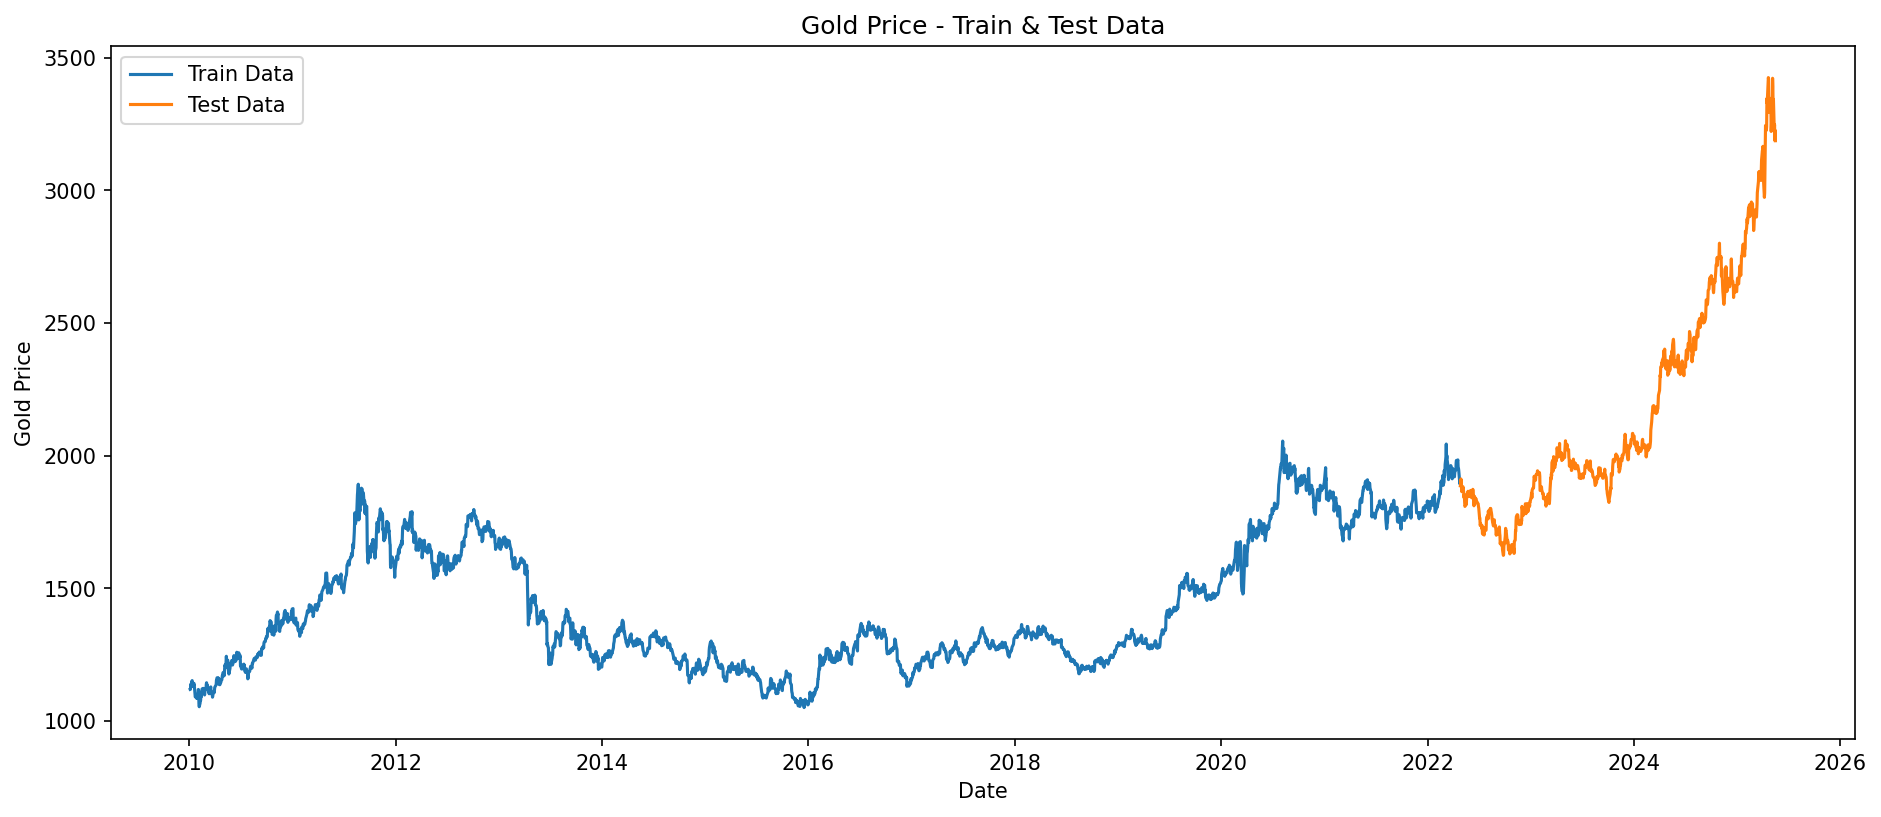

In [69]:
# Thiết lập kích thước biểu đồ với chiều rộng full (ví dụ 15 inch)
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ biểu đồ cho tập huấn luyện (train)
plt.plot(train_data['Price'], label='Train Data')

# Vẽ biểu đồ cho tập kiểm tra (test)
plt.plot(test_data['Price'], label='Test Data')

# Thêm tiêu đề và nhãn
plt.title('Gold Price - Train & Test Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')

# Chú thích
plt.legend()

# Hiển thị biểu đồ
plt.grid(color='white')
plt.show()

### 4. Thông tin chi tiết của tập Train và Test

In [70]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2010-01-04 to 2022-04-26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3132 non-null   float64
 1   Open    3132 non-null   float64
 2   High    3132 non-null   float64
 3   Low     3132 non-null   float64
dtypes: float64(4)
memory usage: 122.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2022-04-27 to 2025-05-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   783 non-null    float64
 1   Open    783 non-null    float64
 2   High    783 non-null    float64
 3   Low     783 non-null    float64
dtypes: float64(4)
memory usage: 30.6 KB


## 5. Khởi tạo và huấn luyện mô hình RNN

In [71]:
from keras.layers import SimpleRNN, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [72]:
# Chuẩn hóa toàn bộ các features
features = ['Price', 'Open', 'High', 'Low']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [73]:
import numpy as np
# Số bước thời gian đầu vào
lookback = 120 

# Chuẩn bị dữ liệu cho RNN
X = []
y = []

# Xây dựng các chuỗi đầu vào (input sequences) dựa trên `lookback` 
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])  # Lấy n bước thời gian trước đó
    y.append(scaled_data[i, 0])  # Giá trị tiếp theo làm mục tiêu

X, y = np.array(X), np.array(y)

In [74]:
# Tách dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [75]:
from keras.models import Sequential
# Xây dựng mô hình RNN
model = Sequential()

# Thêm lớp Input để xác định hình dạng đầu vào
model.add(Input(shape=(lookback, 4)))

# Thêm các lớp RNN và Dropout
model.add(SimpleRNN(units=48, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=48, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))

# Thêm lớp đầu ra
model.add(Dense(units=1))  # Dự đoán một giá trị (giá vàng tiếp theo)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Hiển thị cấu trúc mô hình
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)             │ (None, 120, 48)             │           2,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 120, 48)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (None, 48)                  │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Huấn luyện mô hình
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.1782 - val_loss: 0.0227
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0162 - val_loss: 0.0053
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0020 - val_loss: 8.1024e-04
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016 - val_loss: 6.5382e-04
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 

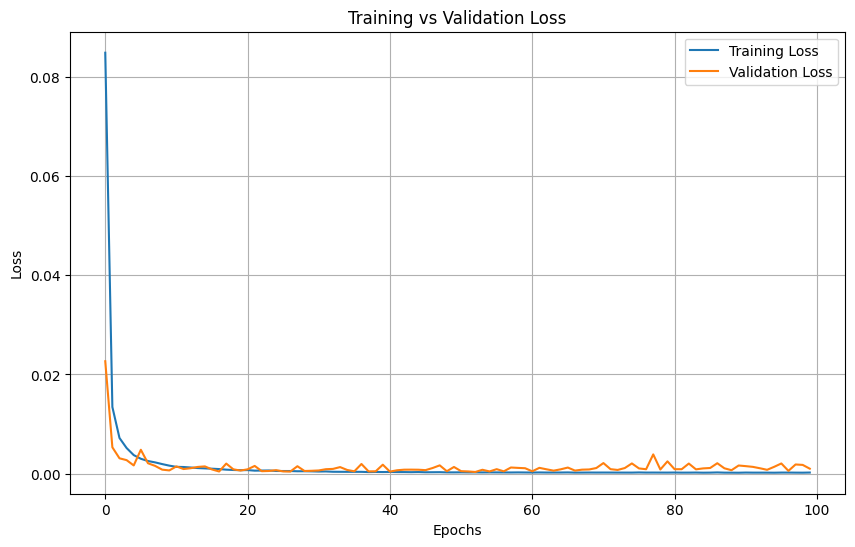

In [77]:
import matplotlib.pyplot as plt

# Trích xuất loss và val_loss từ history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# Dự đoán trên tập kiểm tra
predicted_prices = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [79]:
# Đưa y_test và predicted_prices về shape (n, 1) để inverse_transform
predicted_prices = predicted_prices.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Chỉ inverse cột đầu tiên (giá vàng), nên cần tạo array đúng shape: (n, 4)
# => Lấp 3 cột còn lại bằng 0 (vì không dùng đến), chỉ giữ cột giá vàng
pad = np.zeros((len(predicted_prices), 3))  # Tạo mảng 0 có shape phù hợp
y_test_full = np.concatenate([y_test_reshaped, pad], axis=1)
predicted_full = np.concatenate([predicted_prices, pad], axis=1)

# Inverse transform để đưa về giá trị gốc
predicted_prices_inv = scaler.inverse_transform(predicted_full)[:, 0]
y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Tính lại các chỉ số đánh giá trên dữ liệu đã inverse
mae = mean_absolute_error(y_test_inv, predicted_prices_inv)
mape = mean_absolute_percentage_error(y_test_inv, predicted_prices_inv) * 100
rmse = np.sqrt(mean_squared_error(y_test_inv, predicted_prices_inv))
r2 = r2_score(y_test_inv, predicted_prices_inv)

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 31.152848040456753
MAPE: 1.3577944244846385%
RMSE: 43.846632665075866
R²: 0.9894199088447461


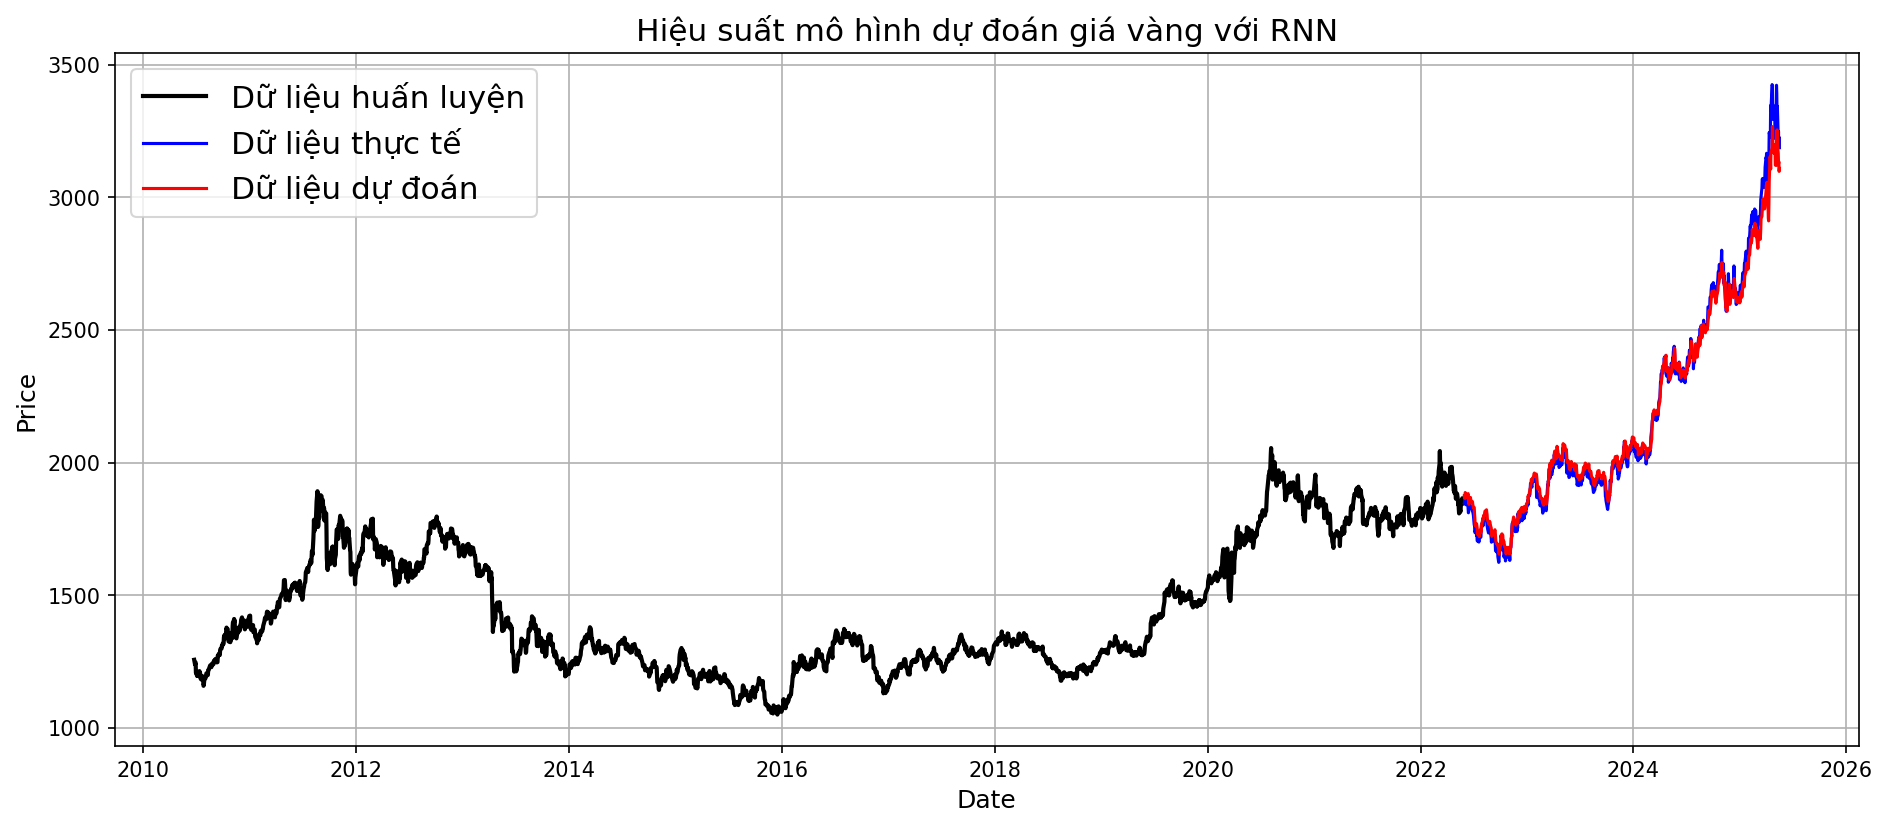

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Đảo chuẩn hóa y_train
y_train_reshaped = y_train.reshape(-1, 1)
pad_train = np.zeros((len(y_train), 3))
y_train_full = np.concatenate([y_train_reshaped, pad_train], axis=1)
y_train_rescaled = scaler.inverse_transform(y_train_full)[:, 0]

# Đảo chuẩn hóa y_test và predicted
y_test_reshaped = y_test.reshape(-1, 1)
pad_test = np.zeros((len(y_test), 3))
y_test_full = np.concatenate([y_test_reshaped, pad_test], axis=1)
predicted_full = np.concatenate([predicted_prices, pad_test], axis=1)

y_test_rescaled = scaler.inverse_transform(y_test_full)[:, 0]
predictions_rescaled = scaler.inverse_transform(predicted_full)[:, 0]

# Vẽ biểu đồ
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ dữ liệu huấn luyện
plt.plot(df.index[lookback:train_size + lookback], y_train_rescaled, color='black', lw=2, label='Dữ liệu huấn luyện')

# Vẽ dữ liệu thực tế từ tập kiểm tra
plt.plot(df.index[train_size + lookback:], y_test_rescaled, label='Dữ liệu thực tế', color='blue')

# Vẽ dữ liệu dự đoán
plt.plot(df.index[train_size + lookback:], predictions_rescaled, label='Dữ liệu dự đoán', color='red')

# Thêm tiêu đề, nhãn, và chú thích
plt.title('Hiệu suất mô hình dự đoán giá vàng với RNN', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.legend(['Dữ liệu huấn luyện', 'Dữ liệu thực tế', 'Dữ liệu dự đoán'], prop={'size': 15})

plt.show()